In [46]:
import immrax as irx
from immrax.utils import (
    gen_ics,
    draw_trajectory_2d,
    draw_refined_trajectory_2d,
    run_times,
)
from immrax.embedding import AuxVarEmbedding

import jax
import jax.numpy as jnp
from jaxtyping import Float, Array

from casadi import MX, Function, Opti, tanh
import numpy as onp

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [47]:
# Vehicle model parameters
t0 = 0
tf = 3
du = 0.05  # Size of control discretization
dtdu = 5  # Number of integration time steps per control discretization
x0 = onp.array([8, 7, -onp.sqrt(3), -1])

# Platoon parameters
num_agents = 6
displacement = 0.2 * jnp.array([jnp.sqrt(3), 1, 0, 0])
x0_platoon = x0
for i in range(1, num_agents):
    x0_platoon = jnp.concatenate((x0_platoon, x0 + i * displacement))


# Obstacle / disturbance parameters
obstacle_center = (4, 4)
obstacle_radius = 2.25
obstacle_padding = 1.3
w_nom = jnp.zeros(2 * num_agents)
w_bounds = irx.icentpert(jnp.zeros(2 * num_agents), 1e-2 * jnp.ones(2 * num_agents))

In [48]:
class VehicleControl:
    def __init__(self, n_horizon=20, u_step=0.25, euler_steps=10):
        self.n_horizon = n_horizon
        self.u_step = u_step
        self.euler_steps = euler_steps
        self.ulim = 5

        x = MX.sym("x", 4, 1)  # [px, py, vx, vy]
        u = MX.sym("u", 2, 1)  # [ax, ay]

        xdot = MX(4, 1)
        xdot[0] = x[2]
        xdot[1] = x[3]
        xdot[2] = self.ulim * tanh(u[0] / self.ulim)
        xdot[3] = self.ulim * tanh(u[1] / self.ulim)

        f = Function("f", [x, u], [xdot], ["x", "u"], ["xdot"])

        N = self.n_horizon

        def euler_integ(x, u):
            step = self.u_step / self.euler_steps
            for t in onp.arange(0, self.u_step, step):
                x = x + step * f(x, u)
            return x

        euler_res = euler_integ(x, u)
        F = Function("F", [x, u], [euler_res], ["x", "u"], ["x_next"])

        self.opti = Opti()
        self.xx = self.opti.variable(4, N + 1)
        self.uu = self.opti.variable(2, N)
        self.x0 = self.opti.parameter(4, 1)
        self.slack = self.opti.variable(1, N)

        self.opti.subject_to(self.xx[:, 0] == self.x0)
        J = 0
        for n in range(N):
            # Dynamics constraints
            self.opti.subject_to(self.xx[:, n + 1] == F(self.xx[:, n], self.uu[:, n]))

            # Penalize state and control effort
            J += (
                self.xx[0, n] ** 2
                + self.xx[1, n] ** 2
                + 0.5 * self.uu[0, n] ** 2
                + 0.5 * self.uu[1, n] ** 2
            )
            if n > 0:
                # Penalize large control changes
                J += 5e-3 * (self.uu[0, n] - self.uu[0, n - 1]) ** 2 + 5 * (
                    self.uu[1, n] - self.uu[1, n - 1]
                )
            J += 1e5 * self.slack[0, n] ** 2

            # Obstacle constraints
            self.opti.subject_to(
                (self.xx[0, n] - obstacle_center[0]) ** 2
                + (self.xx[1, n] - obstacle_center[1]) ** 2
                >= (obstacle_radius * obstacle_padding) ** 2 - self.slack[0, n]
            )
            # self.opti.subject_to(
            #     (self.xx[0, n] + 4) ** 2 + (self.xx[1, n] - 4) ** 2
            #     >= 3**2 - self.slack[0, n]
            # )

        # Final state penalty
        J += (
            100 * self.xx[0, N] ** 2 + 100 * self.xx[1, N] ** 2 + 1 * self.xx[3, N] ** 2
        )
        self.opti.minimize(J)

        # Actuation constraints
        self.opti.subject_to(self.opti.bounded(-self.ulim, self.uu[0, :], self.ulim))
        self.opti.subject_to(self.opti.bounded(-self.ulim, self.uu[1, :], self.ulim))

        self.opti.solver(
            "ipopt",
            {"print_time": 0},
            {
                # "linear_solver": "mumps",
                "print_level": 0,
                "sb": "yes",
                "max_iter": 100000,
            },
        )

    def u(self, t, x):
        self.opti.set_value(self.x0, x)
        for n in range(self.n_horizon + 1):
            self.opti.set_initial(self.xx[:, n], x)
        sol = self.opti.solve()
        # print(sol.value(self.slack))
        return sol.value(self.uu[:, 0]), sol.value(self.xx[:, 1])

    def make_trajectory(self, t0, tf, x0):
        ts = onp.arange(t0, tf, self.u_step)
        us = onp.zeros((len(ts), 2))
        xs = onp.zeros((len(ts) + 1, x0.shape[0]))
        xs[0] = x0

        for i, t in enumerate(ts):
            us[i], xs[i + 1] = self.u(t, xs[i])

        return ts, xs, us

In [49]:
ts, xs, us = VehicleControl(u_step=du, euler_steps=dtdu).make_trajectory(t0, tf, x0)

In [50]:
class Platoon(irx.System):
    num_agents: int
    states_per_vehicle: int = 4  # px py vx vy
    ulim: Float[Array, "2 1"] = jnp.array([5.0, 5.0])

    kp: float = 5
    kv: float = 5

    def __init__(self, n: int) -> None:
        self.num_agents = n
        self.xlen = self.states_per_vehicle * n
        self.evolution = "continuous"

    def f(
        self,
        t: float,
        x: Float[Array, "4*num_agents"],
        u: Float[Array, "2"],
        w: Float[Array, "2*num_agents"],
    ) -> Float[Array, "4*num_agents"]:
        leader_state = x[: self.states_per_vehicle]
        input_softmax = self.ulim * jnp.tanh(u / self.ulim)
        dynamics = jnp.array(
            [
                leader_state[2],
                leader_state[3],
                input_softmax[0] + w[0],
                input_softmax[1] + w[1],
            ]
        )

        for i in range(1, self.num_agents):  # TODO: This can scan
            followed_state = x[
                (i - 1) * self.states_per_vehicle : i * self.states_per_vehicle
            ]
            follower_state = x[
                i * self.states_per_vehicle : (i + 1) * self.states_per_vehicle
            ]

            followed_speed = jnp.linalg.norm(followed_state[2:4])
            pd_control_x = self.kp * (
                followed_state[0]
                - follower_state[0]
                - 0.5 * followed_state[2] / followed_speed
            ) + self.kv * (followed_state[2] - follower_state[2])
            pd_control_y = self.kp * (
                followed_state[1]
                - follower_state[1]
                - 0.5 * followed_state[3] / followed_speed
            ) + self.kv * (followed_state[3] - follower_state[3])

            follower_dynamics = jnp.array(
                [
                    follower_state[2],
                    follower_state[3],
                    pd_control_x + w[2 * i],
                    pd_control_y + w[2 * i + 1],
                ]
            )
            dynamics = jnp.concatenate([dynamics, follower_dynamics])

        return dynamics

In [51]:
us = jnp.array(us)


def mpc_inputs(t: jax.Array, x: Float[Array, "4*num_agents"]) -> Float[Array, "2"]:
    # jax.debug.print("t: {0} ({1})", (t / du).astype(int), t / du)
    return us[(t / du).astype(int)]


disturbances = gen_ics(w_bounds, int((tf - t0) / du) * dtdu)
# print(disturbances)


def disturbance(
    t: float, x: Float[Array, "4*num_agents"]
) -> Float[Array, "2*num_agents"]:
    # return w_nom
    return disturbances[(t / du).astype(int)]


platoon = Platoon(num_agents)
traj = platoon.compute_trajectory(
    t0, tf, x0_platoon, (mpc_inputs, disturbance), solver="euler", dt=du / dtdu
)

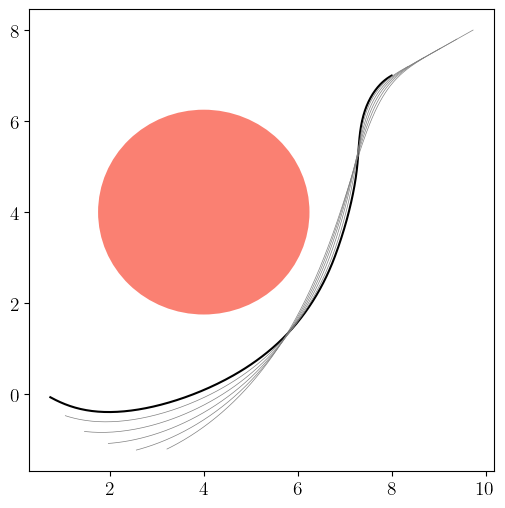

In [52]:
fig = plt.figure(figsize=(6, 6))
ax = plt.gca()

circle = patches.Circle(
    obstacle_center, obstacle_radius, facecolor="salmon", label="Obstacle"
)
ax.add_patch(circle)  # Obstacle

# ax.plot(xs[:, 0], xs[:, 1], color="black", label="Nominal Trajectory")  # MPC trajectory
ax.plot(
    traj.ys[:, 0], traj.ys[:, 1], color="black", label="Nominal Trajectory"
)  # immrax nominal trajectory
for i in range(1, num_agents):
    ax.plot(traj.ys[:, 4 * i], traj.ys[:, 4 * i + 1], color="gray", linewidth=0.5)

Unrefined interval based rechable sets

In [53]:
def disturbance_int(t: float, x: Float[Array, "4*num_agents"]) -> irx.Interval:
    return w_bounds


x0_platoon_int = irx.i2ut(irx.interval(x0_platoon))
platoon_int_unrefined = irx.natemb(platoon)
platoon_int_unrefined.compute_trajectory(
    t0,
    du / dtdu,
    x0_platoon_int,
    (mpc_inputs, disturbance_int),
    solver="euler",
    dt=du / dtdu,
)  # JIT compile
print("JIT compiled unrefined trajectory computation")

traj_int_unrefined, times = run_times(
    1,
    platoon_int_unrefined.compute_trajectory,
    t0,
    tf,
    x0_platoon_int,
    (mpc_inputs, disturbance_int),
    solver="euler",
    dt=du / dtdu,
)
print(
    f"Unrefined trajectory computation took: {times.mean():.4g} ± {times.std():.4g} s"
)

JIT compiled unrefined trajectory computation
Unrefined trajectory computation took: 1.605 ± 0 s


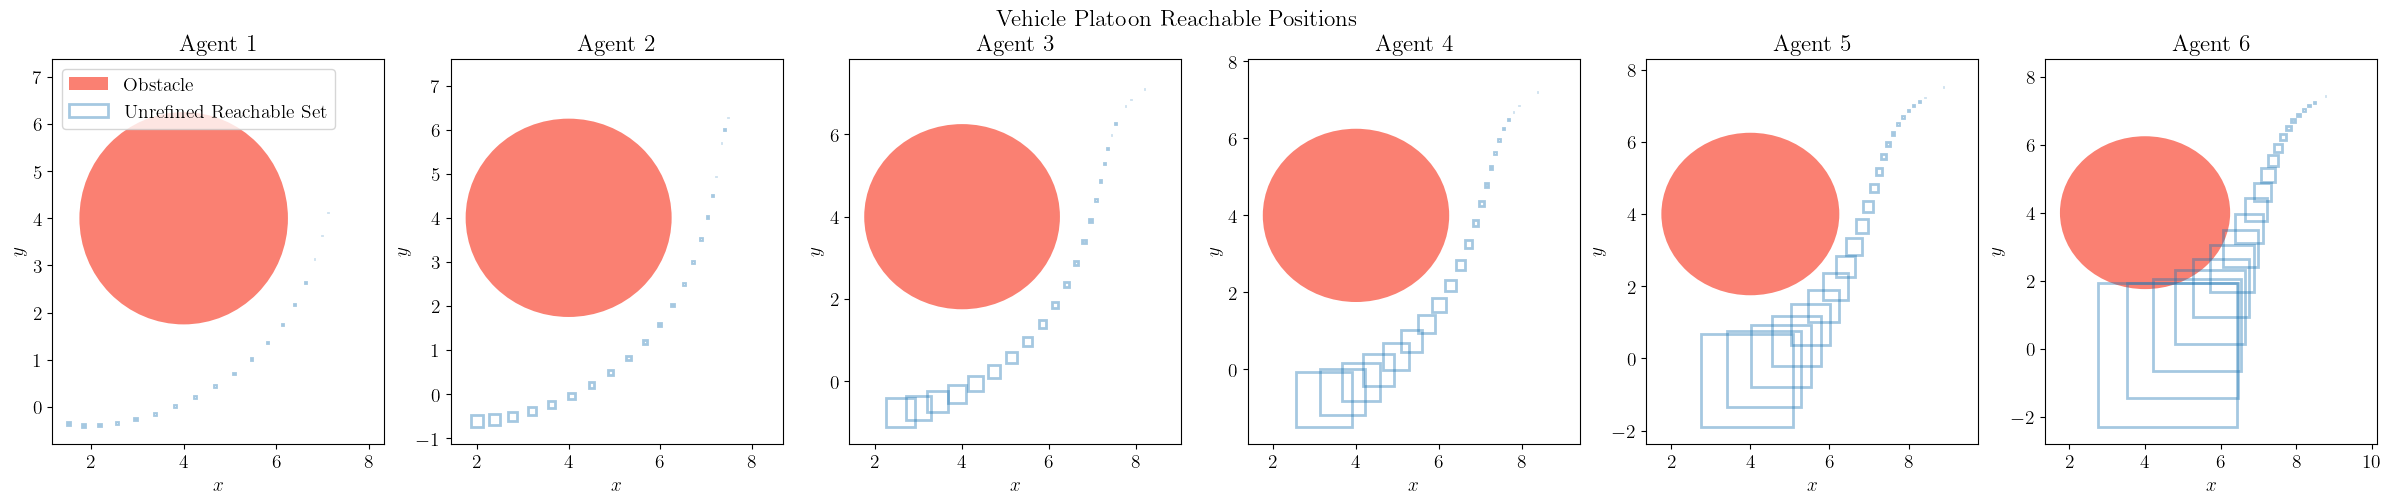

In [54]:
plt.rcParams.update({"text.usetex": True, "font.family": "CMU Serif", "font.size": 14})
plot_frequency = 10

traj_int_unrefined.tfinite = jnp.where(
    jnp.isfinite(traj_int_unrefined._ys).all(axis=1),
    jnp.ones_like(traj_int_unrefined.tfinite, dtype=bool),
    jnp.zeros_like(traj_int_unrefined.tfinite, dtype=bool),
)  # Plot only until trajectory overflows
traj_int_unrefined.tfinite = (
    jnp.zeros_like(traj_int_unrefined.tfinite, dtype=bool)
    .at[::plot_frequency]
    .set(traj_int_unrefined.tfinite[::plot_frequency])
)  # Don't plot interval at every timestep

fig, ax = plt.subplots(1, num_agents, figsize=(5 * num_agents, 5))
fig.suptitle("Vehicle Platoon Reachable Positions")
ax = ax.flatten()

for i in range(num_agents):
    plt.sca(ax[i])
    circle = patches.Circle(
        obstacle_center, obstacle_radius, facecolor="salmon", label="Obstacle"
    )
    ax[i].add_patch(circle)
    draw_trajectory_2d(
        traj_int_unrefined, vars=(4 * i, 4 * i + 1), label="Unrefined Reachable Set"
    )
    ax[i].set_title(f"Agent {i + 1}")
    ax[i].set_xlabel("$x$")
    ax[i].set_ylabel("$y$")
    if i == 0:
        ax[i].legend()


In [55]:
pvx = jnp.array([1.0, 0, 1.0, 0])
pvy = jnp.array([0.0, 1.0, 0, 1.0])
pairings = jnp.zeros((2 * num_agents, 4 * num_agents))
for i in range(num_agents):
    pairings = pairings.at[2 * i, 4 * i : 4 * i + 4].set(pvx)
    pairings = pairings.at[2 * i + 1, 4 * i : 4 * i + 4].set(pvy)
# TODO: try pairing position of follower with leader
H = jnp.vstack([jnp.eye(4 * num_agents), pairings])

x0_platoon_lifted = irx.i2ut(irx.interval(H @ x0_platoon))
platoon_int_aux = AuxVarEmbedding(platoon, H)

traj_int_aux = platoon_int_aux.compute_trajectory(
    t0,
    du / dtdu,
    x0_platoon_lifted,
    (mpc_inputs, disturbance_int),
    solver="euler",
    dt=du / dtdu,
)
print("JIT compiled refined trajectory computation")


traj_int_aux, times = run_times(
    1,
    platoon_int_aux.compute_trajectory,
    t0,
    tf,
    x0_platoon_lifted,
    (mpc_inputs, disturbance_int),
    solver="euler",
    dt=du / dtdu,
)
print(f"Refined trajectory computation took: {times.mean():.4g} ± {times.std():.4g} s")
old_traj_int_aux = traj_int_aux

JIT compiled refined trajectory computation
Refined trajectory computation took: 4.547 ± 0 s


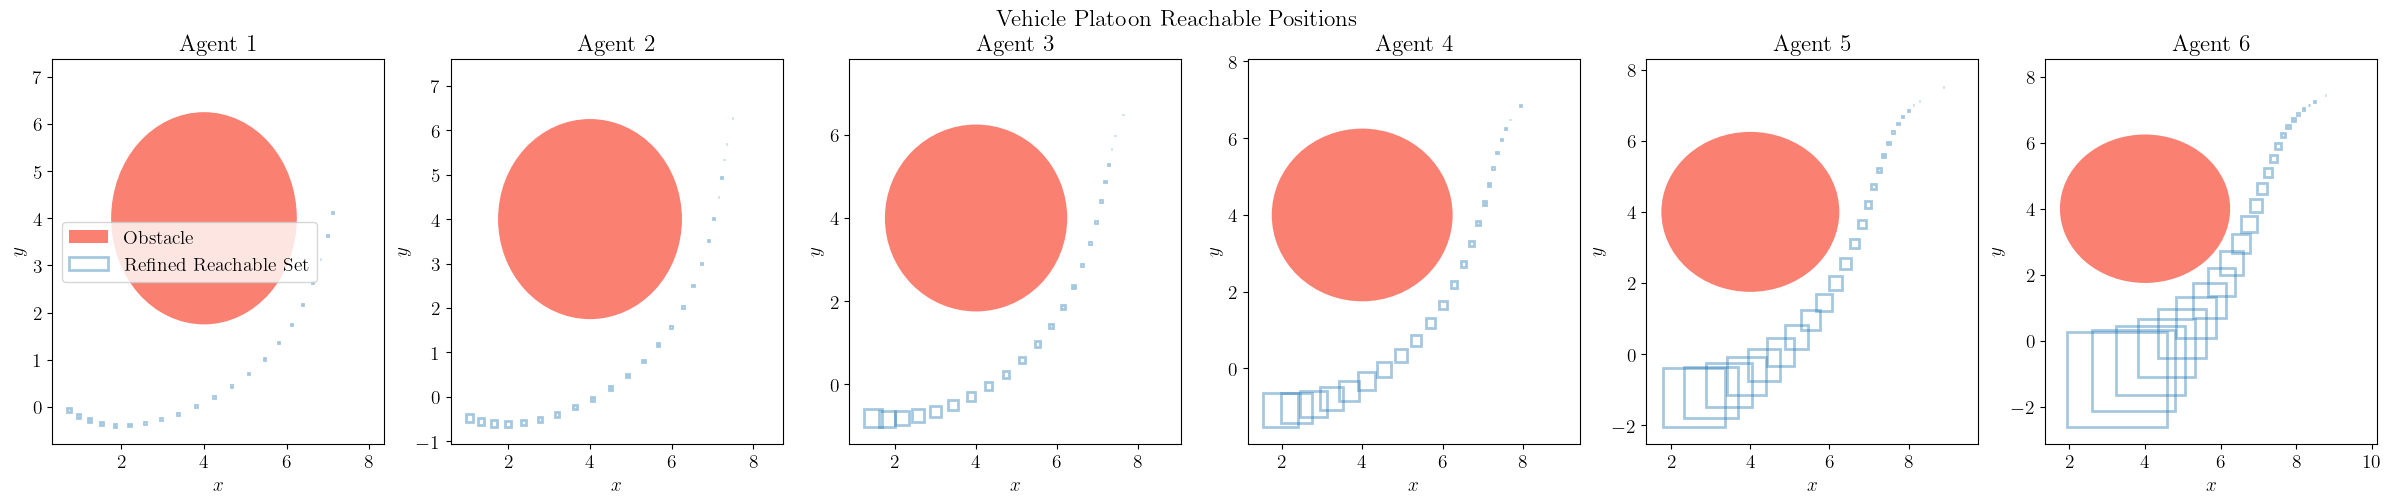

In [56]:
traj_int_aux.tfinite = (
    jnp.zeros_like(old_traj_int_aux.tfinite, dtype=bool)
    .at[::plot_frequency]
    .set(old_traj_int_aux.tfinite[::plot_frequency])
)  # Don't plot interval at every timestep

fig, ax = plt.subplots(1, num_agents, figsize=(5 * num_agents, 5))
fig.suptitle("Vehicle Platoon Reachable Positions")
ax = ax.flatten()

for i in range(num_agents):
    plt.sca(ax[i])
    circle = patches.Circle(
        obstacle_center, obstacle_radius, facecolor="salmon", label="Obstacle"
    )
    plt.gca().add_patch(circle)
    # draw_refined_trajectory_2d(traj_int_aux, H, vars=(4 * i, 4 * i + 1)) # This is very slow
    draw_trajectory_2d(
        traj_int_aux, vars=(4 * i, 4 * i + 1), label="Refined Reachable Set"
    )
    ax[i].set_title(f"Agent {i + 1}")
    ax[i].set_xlabel("$x$")
    ax[i].set_ylabel("$y$")
    if i == 0:
        ax[i].legend()

    # NOTE: This works with just first-order sampling, don't need second order

In [57]:
for i in range(3, 13, 3):
    platoon = Platoon(i)

    pvx = jnp.array([1.0, 0, 1.0, 0])
    pvy = jnp.array([0.0, 1.0, 0, 1.0])
    pairings = jnp.zeros((2 * i, 4 * i))
    for j in range(i):
        pairings = pairings.at[2 * j, 4 * j : 4 * j + 4].set(pvx)
        pairings = pairings.at[2 * j + 1, 4 * j : 4 * j + 4].set(pvy)
    H = jnp.vstack([jnp.eye(4 * i), pairings])

    x0_platoon = x0
    for j in range(1, i):
        x0_platoon = jnp.concatenate((x0_platoon, x0 + j * displacement))
    x0_platoon_int = irx.interval(x0_platoon)
    x0_platoon_lifted = irx.i2ut(irx.interval(H) @ x0_platoon)

    def disturbance_int(t: float, x: Float[Array, "4*num_agents"]) -> irx.Interval:
        return irx.icentpert(jnp.zeros(2 * i), 1e-2 * jnp.ones(2 * i))

    auxsys = AuxVarEmbedding(platoon, H)
    traj_int_aux = auxsys.compute_trajectory(
        t0,
        du / dtdu,
        x0_platoon_lifted,
        (mpc_inputs, disturbance_int),
        solver="euler",
        dt=du / dtdu,
    )

    traj_int_aux, times = run_times(
        1,
        auxsys.compute_trajectory,
        t0,
        tf,
        x0_platoon_lifted,
        (mpc_inputs, disturbance_int),
        solver="euler",
        dt=du / dtdu,
    )

    final_bound = irx.ut2i(traj_int_aux.ys[-1])
    final_bound_size = (
        final_bound.upper[4 * (i - 1)] - final_bound.lower[4 * (i - 1)]
    ) * (final_bound.upper[4 * (i - 1) + 1] - final_bound.lower[4 * (i - 1) + 1])
    print(
        f"Refined trajectory computation took: {times.mean():.4g} ± {times.std():.4g} s"
    )
    print(f"Final refined bound size: {final_bound_size:.4g}")

Refined trajectory computation took: 1.437 ± 0 s
Final refined bound size: 0.1824
Refined trajectory computation took: 5.423 ± 0 s
Final refined bound size: 7.589
Refined trajectory computation took: 13.7 ± 0 s
Final refined bound size: nan
Refined trajectory computation took: 38.33 ± 0 s
Final refined bound size: nan
